## Extraction Bench: Lesson 1
### Using a non-polar solute to extract a solute from water

In this tutorial, I am going to walk you through how our extraction environment works and hopefully give some insight into how an
RL agent might interact with the environment. In this extraction we are going to be using water to extract sodium and
chlorine from oil. We are going to be using this jupyter notebook in order to interact
with the environment.

In [1]:
import sys
sys.path.append('../../')
from chemistrylab.chem_algorithms import material, vessel
from chemistrylab.benches.general_bench import *
from chemistrylab.chem_algorithms.reward import RewardGenerator
import importlib
from chemistrylab.reactions.reaction_info import ReactInfo, REACTION_PATH
from chemistrylab.lab.shelf import Shelf
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches


# Creating a Shelf filled with Vessels

Here we create a shelf containing all of the vessels required for this material. The extraction vessel will have NaCl dissolved in oil, two extra vessels will be provided, one to extract the salt and the other to pour out any waste material (oil).

In [2]:
def make_solvent(mat):
    "Makes a (very large) Vessel with a single material"
    solvent_vessel = vessel.Vessel(
        label=f'{mat} Vessel',
    )
    # create the material dictionary for the solvent vessel
    solvent_class = material.REGISTRY[mat]()
    solvent_class.set_solvent_flag(True)
    solvent_class.mol=1e6
    solvent_vessel.material_dict = {mat:solvent_class}
    # instruct the vessel to update its material dictionary
    return solvent_vessel


extraction_vessel = vessel.Vessel(label='Extract Vessel')
# initialize H2O
C6H14 = material.C6H14(mol=1)
# Get dissolved NaCl
dissolved = material.NaCl().dissolve()
for d in dissolved:
    d.mol=dissolved[d]
mats = [C6H14]+[d for d in dissolved]
# material_dict
material_dict = {mat._name:mat for mat in mats}
# Set up the vessel
extraction_vessel.material_dict=material_dict
extraction_vessel.validate_solvents()
extraction_vessel.validate_solutes()

shelf = Shelf([  
extraction_vessel,
vessel.Vessel("Extract Beaker"),
vessel.Vessel("Waste"),
make_solvent("C6H14"),
make_solvent("H2O")
], n_working = 2)

print(shelf)

Shelf: (Extract Vessel, Extract Beaker, Waste, C6H14 Vessel, H2O Vessel)


# Creating the Actions

Actions are parameterized by a named tuple:
```python
class Action(NamedTuple):
    vessels: Tuple[int]
    parameters: Tuple[tuple]
    event_name: str
    affected_vessels: Optional[Tuple[int]]
    dt: float
    terminal: bool
```

Note: One action object may correspond to multiple actions with different parameters.

For example:
```python
Action([0], [[1],[2],[3],[4]],  'drain by pixel', [1],  0.01, False)
```
corresponds to four actions, each pouring from the vessel at index 0 in the shelf to the vessel at index 1, but each action pours a different number of pixels (from 0 to 4).



In [3]:

#Recall the shelf:         0                1         2          3           4
#           Shelf: (Extract Vessel, Extract Beaker, Waste, C6H14 Vessel, H2O Vessel)

#Setting the volumes to pour (in liters)
amounts=np.linspace(0.2,1,5).reshape([5,1])
#setting the pixels to drain (each pixel represents 10ml of draining in this case)
pixels = np.arange(2,12,2).reshape([5,1])
        
actions = [
    # Pouring the extraction vessel into the extraciton beaker
    Action([0], pixels,              'drain by pixel',[1],  0.01, False),
    # Mixing the extraction vessel
    Action([0],-amounts,             'mix',           None, 0.01, False),
    # Pouring the extraction beaker into the extraction vessel
    Action([1], amounts,             'pour by volume',[0],  0.01, False),
    # Pouring the waste vessel into the extraction vessel
    Action([2], amounts,             'pour by volume',[0],  0.01, False),
    # Pouring the extraction vessel into the waste beaker
    Action([0], amounts,             'pour by volume',[2],  0.01, False),
    # Pouring C6H14 into the extraction vessel
    Action([3], amounts/2,           'pour by volume',[0],  0,    False),
    # Pouring Water into the extraction vessel
    Action([4], amounts/2,           'pour by volume',[0],  0,    False),
    # Waiting for vessels to settle
    Action([0,1,2], 32**amounts/200, 'mix',           None, 0,    False),
    # Ending the experiment
    Action([0], [[0]],               'mix',           None, 0,    True)
]



# Determining the Reward Scheme & observations

Since we just want to get the salt out of the oil, we have our reward function discount the reward if C6H14 is present, and set NaCl as our target, making sure to include dissolved components as NaCl. In order to see what we are doing with the extraction, we will set the observation to just return layer information of our vessels.

In [4]:
e_rew= RewardGenerator(use_purity=False, exclude_solvents=True, include_dissolved=True, exclude_mat="C6H14")
targets = ["NaCl"]

# Mostly unused in this case as reactions don't really need to be modelled
react_info = ReactInfo.from_json(REACTION_PATH+"\\chloro_wurtz.json")

#Just show layer info
observations = ["layers"]

def plot_layers(env, obs,cmap='cubehelix'):
    """Function to display the layer observations"""
    v0 = env.shelf[0]
    fig,axs = plt.subplots(1,obs.shape[0])

    cvals = (np.array([v0.material_dict[mat]._color for mat in v0.solvents]+[0.65])+0.2)%1
    im = axs[-1].imshow([cvals],cmap=cmap,vmin=0,vmax=1)
    colors = [ im.cmap(im.norm(value)) for value in cvals]
    patches = [ mpatches.Patch(color=colors[i],label= name) for i,name in enumerate(list(v0.solvents)+["air"]) ] 
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

    for i,ax in enumerate(axs):
        ax.imshow((np.stack([obs[i]]*40).T[::-1] +0.2)%1,vmin=0,vmax=1,cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.legend()
        fig.tight_layout()
    plt.show()

# Making the Bench

In [5]:
water_oil_bench = GenBench(
shelf,
actions,
react_info,
observations,
reward_function=e_rew,
targets=targets
)

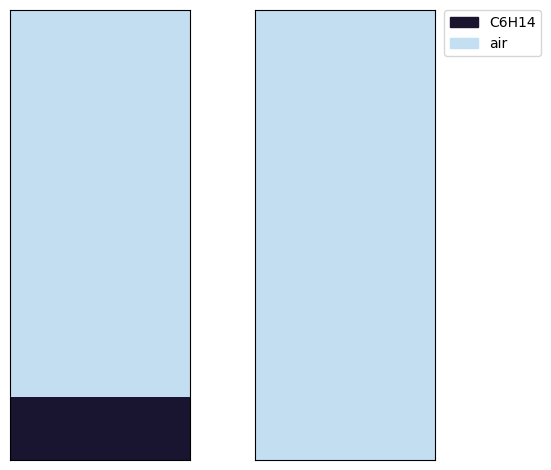

In [6]:
plot_layers(water_oil_bench,water_oil_bench.reset())

These graphs show the contents of each of our containers and the level of separation between the materials. The graphs
to the right then show the layers of materials forming in the container.

When we start the environment we will see that we have a container filled with oil, Na and Cl. Using a polar solvent
we can get the sodium and chlorine to diffuse from the oil into that solvent, in this case we can use water as our polar
solvent!

![image of command](https://ak.picdn.net/shutterstock/videos/4620521/thumb/4.jpg)

![image of graphs with added oil](../../docs/tutorial_figures/extraction-lesson-1/water_oil_1.png)


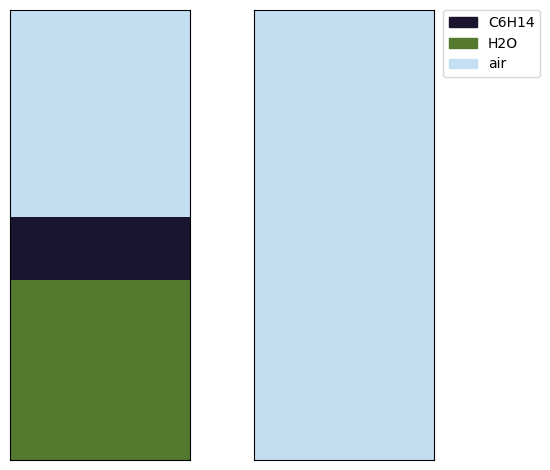

In [7]:
#Pour in water
obs,rew,d,*_ = water_oil_bench.step(33)
obs,rew,d,*_ = water_oil_bench.step(39)
obs,rew,d,*_ = water_oil_bench.step(39)
plot_layers(water_oil_bench,obs)

Now that we've added the water we need to mix the vessel to get the solutes to transfer into the oil, so let's mix the
vessel! As seen in the graph below we can see that based on the layer representation that we have mixed the oil and the water.

![image of command](https://i.pinimg.com/736x/dc/3f/5f/dc3f5fefb5a0a6e24a0799a87dabba8f.jpg)

![image of graphs mixed](../../docs/tutorial_figures/extraction-lesson-1/water_oil_2.png)

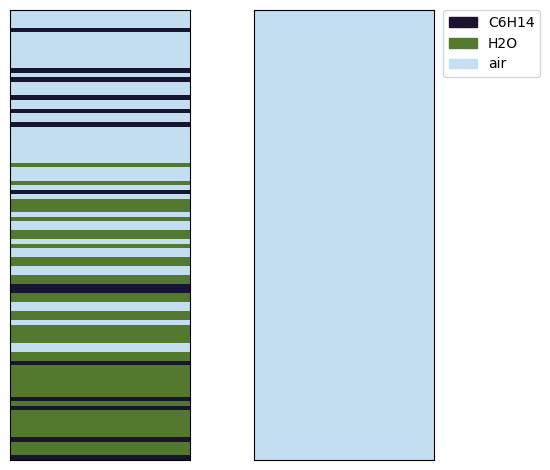

In [8]:
# Mix
obs,rew,d,*_ = water_oil_bench.step(9)

plot_layers(water_oil_bench,obs)

Now that we have done some mixing we need to wait for the oil to settle to the top of the water so we can drain the
water. Keep repeating the following command until the graph settles.

![image of command](https://media.sciencephoto.com/image/c0119092/800wm)

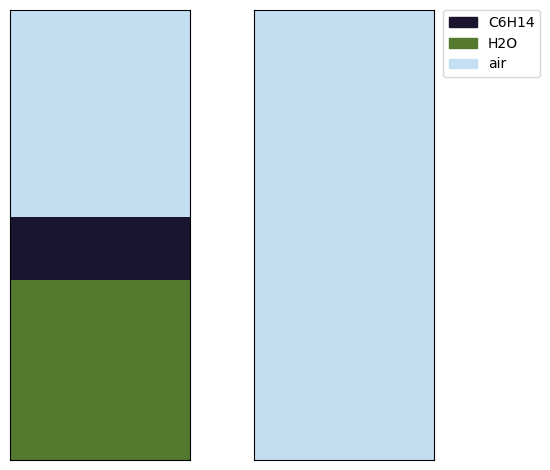

In [9]:
obs,rew,d,*_ = water_oil_bench.step(39)
obs,rew,d,*_ = water_oil_bench.step(39)
plot_layers(water_oil_bench,obs)

Now that the water and oil have settled we want to drain out our water into beaker 1 so that we can pour out our oil
out as waste.

![image of command](../../docs/tutorial_figures/vessel/drain_vessel.png)

Keep repeating the command the changing the multiplier as needed until the graph looks something like this:

![image of graphs draining](../../docs/tutorial_figures/extraction-lesson-1/water_oil_3.png)


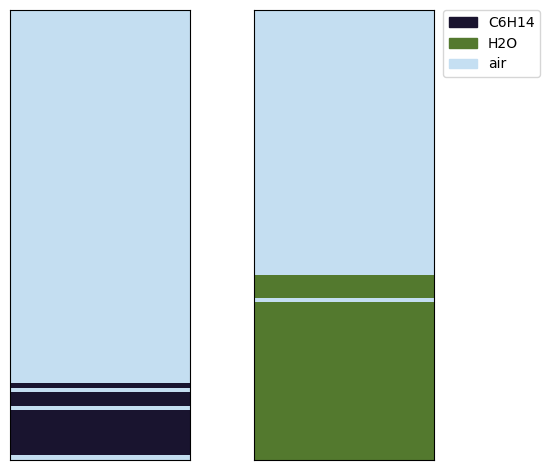

In [10]:
#Pouring
for i in range(4):
    obs,rew,d,*_=water_oil_bench.step(4)
    
plot_layers(water_oil_bench,obs)


Now we pour the oil into vessel 2.

![image of command](https://ak.picdn.net/shutterstock/videos/4620521/thumb/4.jpg)

![image of graphs pouring](../../docs/tutorial_figures/extraction-lesson-1/water_oil_4.png)


Now we just have to empty out the extraction vessel into the waste vessel to get rid of the oil and we are done

In [11]:
obs,rew,d,*_= water_oil_bench.step(24)

obs,final_return,d,*_ = water_oil_bench.step(40)

print(final_return,d)

0.9144585480292636 True


Now if we want to we can pour back the water from vessel 1 into our extraction vessel and repeat the process to get a
more of the sodium out of the oil. However, for an introduction this much should satisfy, now that we have finished,
we want to see how well we did so now we enter the done command.

I hope this tutorial helped with your understanding of how an agent might interact with the extraction environmenment!